# Logistic Regression(Binary Classification) - Eager Execution

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


## Train Data
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* Logistic Classification 통해 보라색과 노란색 y_data(Label)을 구분해 보겠습니다.
* Test 데이터는 붉은색의 위치와 같이 추론시 1의 값을 가지게 됩니다.

x1 | x2 | Y
---- | ---- | ----
1 | 2 | 0
2 | 3 | 0 
3 | 1 | 0
4 | 3 | 1
5 | 3 | 1
6 | 2 | 1


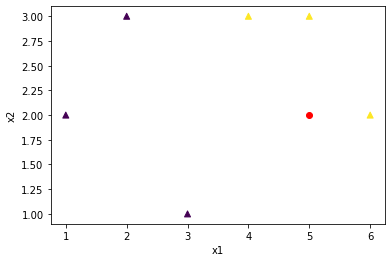

In [9]:
data = np.array([
    # X1,  X2,  y
    [ 1.,  2.,  0. ],
    [ 2.,  3.,  0. ],
    [ 3.,  1.,  0. ],
    [ 4.,  3.,  1. ],
    [ 5.,  3.,  1. ],
    [ 6.,  2.,  1. ]
], dtype=np.float32)

# slice data
# train data
x_train = data[:, :-1] # 6행 2열
y_train = data[:, [-1]] # 6행 1열(마지막 열)

# test data
x_test = [[5.,2.]]
y_test = [[1.]]

x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

colors = [int(y[0] % 3) for y in y_train]
plt.scatter(x1,x2, c=colors , marker='^')
plt.scatter(x_test[0][0],x_test[0][1], c="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

##  Tensorflow Eager
### 위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))#.repeat()
print(datast)

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.float32)>


### 위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

In [11]:
tf.random.set_seed(0)  # for reproducibility

# 0의 값으로 변수 설정
W = tf.Variable(tf.zeros([2,1]), name='weight')
b = tf.Variable(tf.zeros([1]), name='bias') 
# 임의의 값으로 변수 설정
#W = tf.Variable(tf.random.normal((2, 1))) # 2행 1열
#b = tf.Variable(tf.random.normal((1,)))

## Step 1: Hypothesis using matrix(가설 or 모델)
### Sigmoid 함수를 가설로 선언합니다
* Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다

$$
\begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align}
$$

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In [13]:
# 가설
def logistic_regression(features):
    hypothesis  = tf.sigmoid(tf.matmul(features, W) + b)
    return hypothesis

## Step 2: Cost Function (손실 함수)
$$
\begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align}
$$

* 위 두수식을 합치면 아래과 같습니다
$$
\begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align}
$$

In [14]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(logistic_regression(features)) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

## Step 3: Optimizer (Minimize Cost Function)
### Gradient descent
$$ W := W-\alpha \frac { \partial  }{ \partial W } cost(W) $$

In [16]:
# 경사 하강법
# tf.GradientTape() 사용
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

def grad(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features),features,labels)
    return tape.gradient(loss_value, [W,b])

### 추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴합니다.
* Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.
* 가설을 통해 실재 값과 비교한 정확도를 측정합니다

In [17]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.int32))
    return accuracy

## 훈련

In [19]:
# 훈련 반복 횟수 설정
epoch = 1000
for step in range(epoch + 1):
    for features, labels  in iter(dataset):
        grads = grad(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(logistic_regression(features),features,labels)))

Iter: 0, Loss: 0.6821
Iter: 100, Loss: 0.5770
Iter: 200, Loss: 0.5345
Iter: 300, Loss: 0.5052
Iter: 400, Loss: 0.4836
Iter: 500, Loss: 0.4670
Iter: 600, Loss: 0.4534
Iter: 700, Loss: 0.4419
Iter: 800, Loss: 0.4318
Iter: 900, Loss: 0.4227
Iter: 1000, Loss: 0.4143


## Predict (예측)

In [21]:
y_train # labels, 실제값

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [22]:
logistic_regression(x_train).numpy() # prediction, 예측값

array([[0.21676369],
       [0.26433405],
       [0.68672633],
       [0.6295152 ],
       [0.7870086 ],
       [0.9308373 ]], dtype=float32)

In [24]:
# 테스트 데이터에 대한 예측
test_acc = accuracy_fn(logistic_regression(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Testset Accuracy: 1.0000
